# Тест BigARTM на коллекции текстов песен

Описание датасета: http://labrosa.ee.columbia.edu/millionsong/musixmatch#getting
Количество документов: 237,662
Количество уникальных стэммов: 5000

## Создание коллекции формата vowpal wabbit

In [1]:
import os
import sys
import sqlite3
import collections
import pandas as pd
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
%pylab inline

from stemming.porter2 import stem

Populating the interactive namespace from numpy and matplotlib


In [9]:
conn = sqlite3.connect('mxm_dataset.db')
q = "select * from lyrics"
res = conn.execute(q)
swords = set([stem(x) for x in stopwords.words('english')]).union(set(stopwords.words('english')))

In [10]:
def vw_count(num):
    if num == 1:
        return ''
    else:
        return ':{}'.format(num)

one_doc_counter = {}
word_counter = collections.Counter()
docs = res.fetchmany(1)
current_id = docs[0][0]
current_num = 1
if docs[0][2] not in swords:
    one_doc_counter[docs[0][2]] = docs[0][3]
    word_counter[docs[0][2]] += docs[0][3]
with open('vw.lyrics_wsw.txt', 'w') as output_file:
    while docs:
        docs = res.fetchmany(10000)
        for item in docs:
            if item[2] not in swords:
                word_counter[item[2]] += item[3]
                if item[0] == current_id:
                    one_doc_counter[item[2]] = item[3]
                else:
                    counter_line = ' '.join([item + vw_count(one_doc_counter[item]) for item in one_doc_counter])
                    output_line = 'doc{} |@words {}'.format(current_num, counter_line)
                    output_file.write(output_line + '\n')
                    current_id = item[0]
                    one_doc_counter = {}
                    one_doc_counter[item[2]] = item[3]
                    current_num += 1
    counter_line = ' '.join([item + vw_count(one_doc_counter[item]) for item in one_doc_counter])
    output_line = 'doc{} |@words {}'.format(current_num, counter_line)
    output_file.write(output_line + '\n')

## Обучение

### Часть 1: "из коробки"

In [7]:
import artm
batch_vectorizer = artm.BatchVectorizer(data_path='vw.lyrics_wsw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches2')
dictionary = artm.Dictionary()
dictionary.gather(data_path='my_collection_batches2')
offline_model = artm.ARTM(
    num_topics=20,
    dictionary=dictionary,
)

In [8]:
offline_model = artm.ARTM(
    num_topics=20,
    dictionary=dictionary,
)

offline_model.scores.add(artm.PerplexityScore(
        name='PerplexityScore',
        dictionary=dictionary
))
offline_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

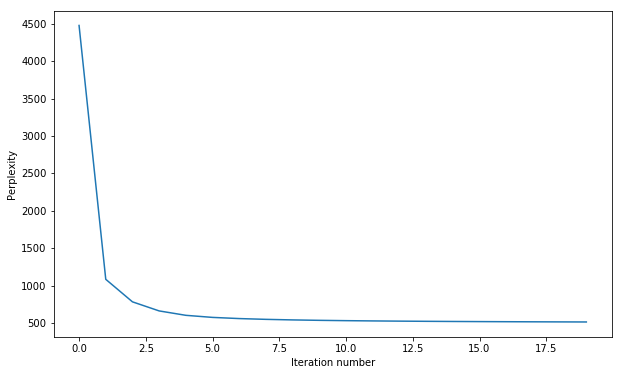

In [10]:
first_perplex_list = offline_model.score_tracker['PerplexityScore'].value
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(first_perplex_list)
ax.set_xlabel('Iteration number')
ax.set_ylabel('Perplexity')

In [11]:
phi = offline_model.get_phi()

Теперь пробуем реализовать интерактивный heatmap, на котором видны все темы сразу

In [12]:
def smart_sort(data, n_words):
    data = data.sort_values(data.columns[0], ascending=False)
    result_data = data.iloc[:n_words]
    data = data.iloc[n_words:]
    for col in data.columns[1:]:
        data = data.sort_values(col, ascending=False)
        result_data = pd.concat([result_data, data.iloc[:n_words]])
        data = data.iloc[n_words:]
    return result_data.iloc[::-1]

In [13]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import numpy as np

data_for_plot = smart_sort(phi, 4)

heatmap = go.Heatmap(
    x = data_for_plot.columns,
    y = data_for_plot.index.values,
    z = data_for_plot.values,
)
layout = go.Layout(
    xaxis=dict(ticks='', side='top'),
    yaxis=dict(ticks='', ticksuffix='  '),
    width=700,
    height=1500,
    autosize=False,
)
fig = go.Figure(
    data = [heatmap],
    layout=layout,
)
iplot(fig)

Темы получились интерпретируемы. Но теперь попробуем добавить регуляризаторы.

### Часть 2: с регуляризаторами

In [14]:
offline_model = artm.ARTM(
    num_topics=20,
    dictionary=dictionary,
    regularizers=[
        artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
        artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05),
        artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=10000000),
    ],
)

offline_model.scores.add(artm.PerplexityScore(
        name='PerplexityScore',
        dictionary=dictionary
))
offline_model.scores.add(artm.TopicKernelScore(
        name='TopicKernelScore',
        probability_mass_threshold=0.05
))
offline_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

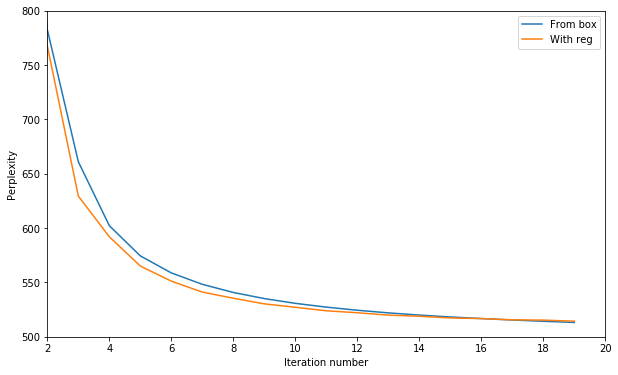

In [15]:
second_perplex_list = offline_model.score_tracker['PerplexityScore'].value
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(first_perplex_list)
ax.plot(second_perplex_list)
ax.set_xlim([2,20])
ax.set_ylim([500,800])
ax.legend(['From box', 'With reg'])
ax.set_xlabel('Iteration number')
ax.set_ylabel('Perplexity')

Видно, что перплексия модели с регуляризатором сходится быстрее

In [16]:
phi = offline_model.get_phi()

In [17]:
phi['index'] = phi.index
phi = phi.drop_duplicates(keep='first', subset='index')
del phi['index']
data_for_plot = smart_sort(phi, 4)

heatmap = go.Heatmap(
    x = data_for_plot.columns,
    y = data_for_plot.index.values,
    z = data_for_plot.values,
)
layout = go.Layout(
    xaxis=dict(ticks='', side='top'),
    yaxis=dict(ticks='', ticksuffix='  '),
    width=700,
    height=1500,
    autosize=False,
)
fig = go.Figure(
    data = [heatmap],
    layout=layout,
)
iplot(fig)

В темах можем обнаружить следующие жанры:

- Рэп (topic_0): ya, fuck, nigga, shit, yo, bitch, ass
- Религиозные (topic_2): us, god, call, home, die, man, lord, name, save, child, pray, follow, jesus
- Что-то про воспоминания (topic_12): time, long, still, last, year, rememb, mani, old
- Какой-то метал (topic_13): dead, burn, kill, blood, death, life, pain, fear, hate, hell
- Лирические песни (topic_14): want, feel, say, way, need, see, everyth, believ, ever, alway
- танцевальная музыка (topic_17): got, let, yeah, everybodi, music, show, whoa, parti


+много топиков, относящихся к конкретному языку (немецкий - topic_16, что-то испанское - topic_15)